In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

import matplotlib.pyplot as plt

from torchvision.utils import make_grid




In [2]:
#@title Get some modules to let time interact

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights (frequencies) during initialization. 
    # These weights (frequencies) are fixed during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None] 
    # this broadcast the 2d tensor to 4d, add the same value across space. 


In [3]:
#@title Diffusion constant and noise strength
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [4]:
#@title Sampler code
num_steps = 500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
              marginal_prob_std,
              diffusion_coeff, 
              batch_size=64, 
              x_shape=(1, 28, 28),
              num_steps=num_steps, 
              device='cuda', 
              eps=1e-3, y=None):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, *x_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

In [5]:
from einops import rearrange
import math

In [6]:
class WordEmbed(nn.Module):
  def __init__(self, vocab_size, embed_dim):
    super(WordEmbed, self).__init__()
    self.embed = nn.Embedding(vocab_size+1, embed_dim)
  
  def forward(self, ids):
    return self.embed(ids)

In [7]:
class CrossAttention(nn.Module):
  def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1,):
    """
    Note: For simplicity reason, we just implemented 1-head attention. 
    Feel free to implement multi-head attention! with fancy tensor manipulations.
    """
    super(CrossAttention, self).__init__()
    self.hidden_dim = hidden_dim
    self.context_dim = context_dim
    self.embed_dim = embed_dim
    self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
    if context_dim is None:
      self.self_attn = True 
      self.key = nn.Linear(hidden_dim, embed_dim, bias=False)     ###########
      self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)  ############
    else:
      self.self_attn = False 
      self.key = nn.Linear(context_dim, embed_dim, bias=False)   #############
      self.value = nn.Linear(context_dim, hidden_dim, bias=False) ############
    
    
  def forward(self, tokens, context=None):
    # tokens: with shape [batch, sequence_len, hidden_dim]
    # context: with shape [batch, contex_seq_len, context_dim]
    if self.self_attn:
        Q = self.query(tokens)
        K = self.key(tokens)  
        V = self.value(tokens) 
    else:
        # implement Q, K, V for the Cross attention 
        Q = self.query(tokens)
        K = self.key(context)
        V = self.value(context)
    #print(Q.shape, K.shape, V.shape)
    ####### YOUR CODE HERE (2 lines)
    scoremats = torch.einsum("BTH,BSH->BTS", Q, K)         # inner product of Q and K, a tensor 
    attnmats = F.softmax(scoremats/np.sqrt(self.embed_dim), dim=-1)          # softmax of scoremats
    #print(scoremats.shape, attnmats.shape, )
    ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # weighted average value vectors by attnmats
    return ctx_vecs


class TransformerBlock(nn.Module):
  """The transformer block that combines self-attn, cross-attn and feed forward neural net"""
  def __init__(self, hidden_dim, context_dim):
    super(TransformerBlock, self).__init__()
    self.attn_self = CrossAttention(hidden_dim, hidden_dim, )
    self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

    self.norm1 = nn.LayerNorm(hidden_dim)
    self.norm2 = nn.LayerNorm(hidden_dim)
    self.norm3 = nn.LayerNorm(hidden_dim)
    # implement a 2 layer MLP with K*hidden_dim hidden units, and nn.GeLU nonlinearity #######
    self.ffn  = nn.Sequential(nn.Linear(hidden_dim, 3*hidden_dim),
                nn.GELU(), nn.Linear(3*hidden_dim, hidden_dim) )
    
    
  def forward(self, x, context=None):
    # Notice the + x as residue connections
    x = self.attn_self(self.norm1(x)) + x
    # Notice the + x as residue connections
    x = self.attn_cross(self.norm2(x), context=context) + x
    # Notice the + x as residue connections
    x = self.ffn(self.norm3(x)) + x
    return x 

class SpatialTransformer(nn.Module):
  def __init__(self, hidden_dim, context_dim):
    super(SpatialTransformer, self).__init__()
    self.transformer = TransformerBlock(hidden_dim, context_dim)

  def forward(self, x, context=None):
    b, c, h, w = x.shape
    x_in = x
    # Combine the spatial dimensions and move the channel dimen to the end
    x = rearrange(x, "b c h w->b (h w) c")
    # Apply the sequence transformer
    x = self.transformer(x, context)
    # Reverse the process
    x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
    # Residue 
    return x + x_in

In [8]:
class UNet_Tranformer(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256, 
               text_dim=256, nClass=10):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings of time.
      text_dim:  the embedding dimension of text / digits. 
      nClass:    number of classes you want to model.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim)
        )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.attn3 = SpatialTransformer(channels[2], text_dim) 
    
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    
    # YOUR CODE: interleave some attention layers with conv layers
    self.attn4 = SpatialTransformer(channels[3], text_dim)                        ######################################

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])   

    self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     #  + channels[2]
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    
    self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)     #  + channels[1]
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1) #  + channels[0]
    
    # The swish activation function
    self.act = nn.SiLU() # lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
    self.cond_embed = nn.Embedding(nClass, text_dim)
  
  def forward(self, x, t, y=None): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.time_embed(t))    
    y_embed = self.cond_embed(y).unsqueeze(1)
    # Encoding path
    h1 = self.conv1(x) + self.dense1(embed) 
    ## Incorporate information from t
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    h3 = self.attn3(h3, y_embed) # Use your attention layers
    h4 = self.conv4(h3) + self.dense4(embed)
    h4 = self.act(self.gnorm4(h4))
    # Your code: Use your additional attention layers! 
    h4 = self.attn4(h4, y_embed)       ##################### ATTENTION LAYER COULD GO HERE IF ATTN4 IS DEFINED

    # Decoding path
    h = self.tconv4(h4) + self.dense5(embed)
    ## Skip connection from the encoding path
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(h + h3) + self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(h + h2) + self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(h + h1)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [9]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [10]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t, y=y)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [11]:
# Create an instance of YourModelClass
score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Load the saved state dictionary
state_dict = torch.load('ckpt_transformer.pth')

# Load the state dictionary into the model
score_model.load_state_dict(state_dict)


<All keys matched successfully>

In [12]:
#@title Training model

continue_training = True #@param {type:"boolean"}
if not continue_training:
  print("initilize new score model...")
  score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
  score_model = score_model.to(device)


n_epochs =   100#@param {'type':'integer'}
## size of a mini-batch
batch_size =  1024 #@param {'type':'integer'}
## learning rate
lr=10e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in tqdm(data_loader):
    x = x.to(device)    
    loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  scheduler.step()
  lr_current = scheduler.get_last_lr()[0]
  print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt_transformer.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/tmp/ipykernel_33027/1075061566.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 51.405475 lr 9.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

1 Average Loss: 25.967561 lr 9.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

2 Average Loss: 21.939384 lr 9.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

3 Average Loss: 21.162569 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

4 Average Loss: 21.100644 lr 9.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

5 Average Loss: 20.700745 lr 8.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

6 Average Loss: 20.565689 lr 8.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

7 Average Loss: 20.299462 lr 8.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

8 Average Loss: 20.111484 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

9 Average Loss: 19.982490 lr 8.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

10 Average Loss: 19.986959 lr 8.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

11 Average Loss: 19.331831 lr 7.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

12 Average Loss: 19.613025 lr 7.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

13 Average Loss: 19.947278 lr 7.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

14 Average Loss: 19.992747 lr 7.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

15 Average Loss: 19.367108 lr 7.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

16 Average Loss: 18.999845 lr 7.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

17 Average Loss: 19.075450 lr 7.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

18 Average Loss: 18.970735 lr 6.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

19 Average Loss: 19.181762 lr 6.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

20 Average Loss: 18.589532 lr 6.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

21 Average Loss: 18.558711 lr 6.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

22 Average Loss: 18.815270 lr 6.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

23 Average Loss: 18.457480 lr 6.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

24 Average Loss: 18.619095 lr 6.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

25 Average Loss: 19.711798 lr 5.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

26 Average Loss: 18.505638 lr 5.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

27 Average Loss: 18.431230 lr 5.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

28 Average Loss: 18.278493 lr 5.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

29 Average Loss: 18.392031 lr 5.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

30 Average Loss: 18.286370 lr 5.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

31 Average Loss: 18.134092 lr 5.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

32 Average Loss: 18.053791 lr 5.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

33 Average Loss: 17.918984 lr 5.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

34 Average Loss: 17.933976 lr 4.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

35 Average Loss: 17.867768 lr 4.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

36 Average Loss: 17.749557 lr 4.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

37 Average Loss: 17.739765 lr 4.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

38 Average Loss: 17.766290 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

39 Average Loss: 17.579191 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

40 Average Loss: 17.659346 lr 4.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

41 Average Loss: 17.641912 lr 4.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

42 Average Loss: 17.499911 lr 4.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

43 Average Loss: 17.628760 lr 4.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

44 Average Loss: 17.488139 lr 4.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

45 Average Loss: 17.347417 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

46 Average Loss: 17.430498 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

47 Average Loss: 17.380856 lr 3.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

48 Average Loss: 17.235322 lr 3.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

49 Average Loss: 17.156646 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

50 Average Loss: 17.305051 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

51 Average Loss: 17.280389 lr 3.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

52 Average Loss: 17.023641 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

53 Average Loss: 17.157777 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

54 Average Loss: 17.168395 lr 3.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

55 Average Loss: 17.024583 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

56 Average Loss: 17.064392 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

57 Average Loss: 17.076426 lr 3.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

58 Average Loss: 16.841204 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

59 Average Loss: 17.017651 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

60 Average Loss: 16.922028 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

61 Average Loss: 16.963884 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

62 Average Loss: 16.883488 lr 2.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

63 Average Loss: 16.853602 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

64 Average Loss: 16.820942 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

65 Average Loss: 16.721126 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

66 Average Loss: 16.879178 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

67 Average Loss: 16.930257 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

68 Average Loss: 16.729150 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

69 Average Loss: 16.653687 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

70 Average Loss: 16.734949 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

71 Average Loss: 16.832720 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

72 Average Loss: 16.635825 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

73 Average Loss: 16.494730 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

74 Average Loss: 16.733273 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

75 Average Loss: 16.505036 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

76 Average Loss: 16.640405 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

77 Average Loss: 16.593907 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

78 Average Loss: 16.687126 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

79 Average Loss: 16.604186 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

80 Average Loss: 16.482924 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

81 Average Loss: 16.487145 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

82 Average Loss: 16.512737 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

83 Average Loss: 16.477683 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

84 Average Loss: 16.477744 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

85 Average Loss: 16.469594 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

86 Average Loss: 16.483273 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

87 Average Loss: 16.345972 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

88 Average Loss: 16.416358 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

89 Average Loss: 16.515454 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

90 Average Loss: 16.670011 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

91 Average Loss: 16.332598 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

92 Average Loss: 16.269003 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

93 Average Loss: 16.473878 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

94 Average Loss: 16.396075 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

95 Average Loss: 16.345639 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

96 Average Loss: 16.513399 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

97 Average Loss: 16.461130 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

98 Average Loss: 16.473199 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

99 Average Loss: 16.256156 lr 2.0e-04


/tmp/ipykernel_33027/1075061566.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_33027/1075061566.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


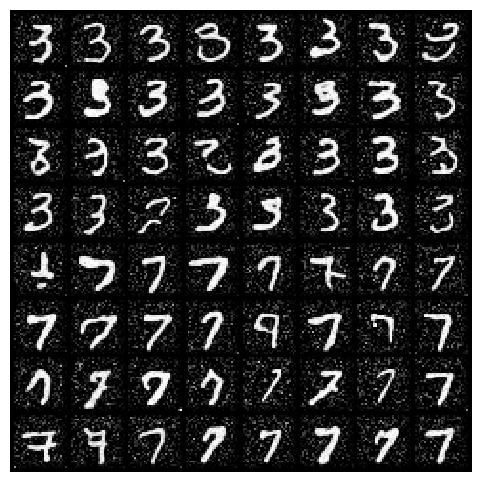

In [13]:
## Load the pre-trained checkpoint from disk.
# device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
# ckpt = torch.load('ckpt.pth', map_location=device)
# score_model.load_state_dict(ckpt)
digit = 3 #@param {'type':'integer'}
sample_batch_size = 64 #@param {'type':'integer'}
num_steps = 250 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
# score_model.eval()
## Generate samples using the specified sampler.

y_input = digit*torch.ones(sample_batch_size, dtype=torch.long)

half_size = sample_batch_size // 2
y_input = torch.cat([3 * torch.ones(half_size, dtype=torch.long), 7 * torch.ones(half_size, dtype=torch.long)], dim=0)


samples = sampler(score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size, 
        num_steps=num_steps,
        device=device,
        y=y_input)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

Generating new images


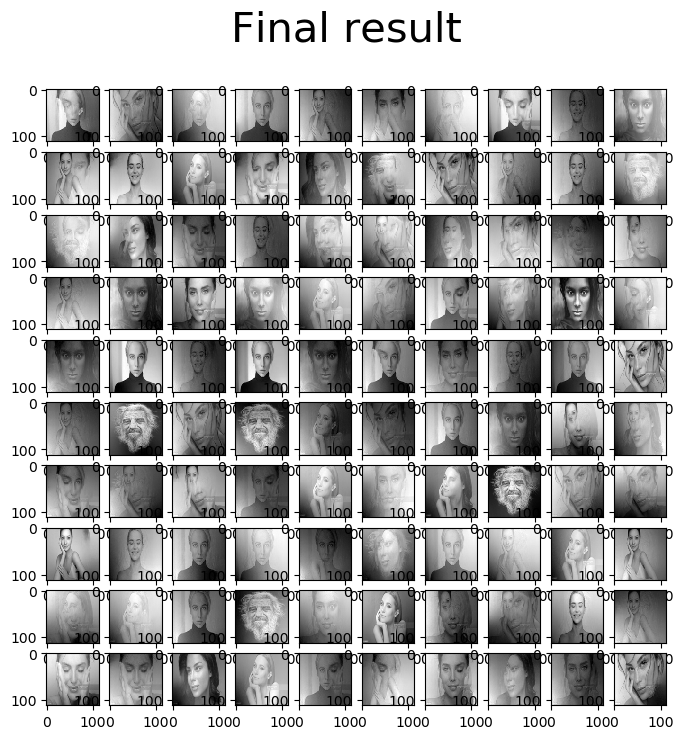

In [112]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="fashion.gif" if fashion else "mnist.gif"
    )
show_images(generated, "Final result")

In [2]:
# Simulate forward diffusion for N steps.
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
  """x0: initial sample value, scalar
  noise_strength_fn: function of time, outputs scalar noise strength
  t0: initial time
  nsteps: number of diffusion steps
  dt: time step size
  """

  # Initialize trajectory
  x = np.zeros(nsteps + 1); x[0] = x0
  t = t0 + np.arange(nsteps + 1)*dt 
  
  # Perform many Euler-Maruyama time steps
  for i in range(nsteps):
    noise_strength = noise_strength_fn(t[i])
    ############ YOUR CODE HERE (2 lines)
    random_normal = np.random.randn()
    x[i+1] = x[i] + np.sqrt(dt)*noise_strength*random_normal
    #####################################
  return x, t


# Example noise strength function: always equal to 1
def noise_strength_constant(t):
  return 1


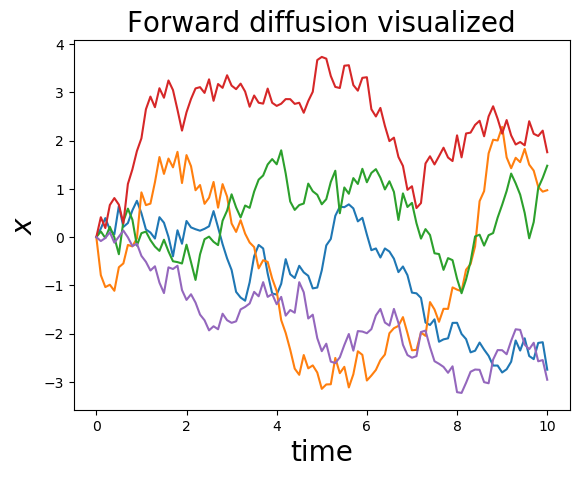

In [3]:
nsteps = 100
t0 = 0
dt = 0.1
noise_strength_fn = noise_strength_constant
x0 = 0

num_tries = 5
for i in range(num_tries):
  x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)
  
  plt.plot(t, x)
  plt.xlabel('time', fontsize=20)
  plt.ylabel('$x$', fontsize=20)
plt.title('Forward diffusion visualized', fontsize=20)
plt.show()

In [4]:
# Simulate forward diffusion for N steps.
def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
  """x0: initial sample value, scalar
  noise_strength_fn: function of time, outputs scalar noise strength
  score_fn: score function
  T: final time
  nsteps: number of diffusion steps
  dt: time step size
  """

  # Initialize trajectory
  x = np.zeros(nsteps + 1); x[0] = x0
  t = np.arange(nsteps + 1)*dt 
  
  # Perform many Euler-Maruyama time steps
  for i in range(nsteps):
    noise_strength = noise_strength_fn(T - t[i])
    score = score_fn(x[i], 0, noise_strength, T-t[i])
    ############ YOUR CODE HERE (2 lines)
    random_normal = np.random.randn()
    x[i+1] = x[i] + (noise_strength**2)*score*dt + np.sqrt(dt)*noise_strength*random_normal
    #####################################
  return x, t


# Example noise strength function: always equal to 1
def score_simple(x, x0, noise_strength, t):
  score = - (x-x0)/((noise_strength**2)*t)
  return score

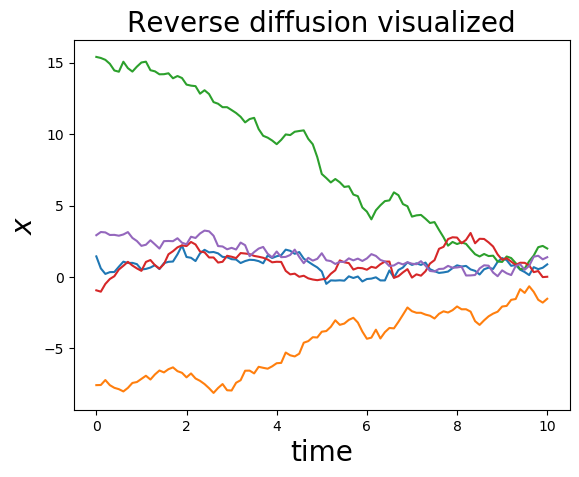

In [5]:
nsteps = 100
t0 = 0
dt = 0.1
noise_strength_fn = noise_strength_constant
score_fn = score_simple
x0 = 0
T = 11


num_tries = 5
for i in range(num_tries):
  x0 = np.random.normal(loc=0, scale=T)   # draw from the noise distribution, which is diffusion for time T w noise strength 1
  x, t = reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt)
  
  plt.plot(t, x)
  plt.xlabel('time', fontsize=20)
  plt.ylabel('$x$', fontsize=20)
plt.title('Reverse diffusion visualized', fontsize=20)
plt.show()